# Interannual variability and seasonality in NMEG sites

In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = '../figures/multiyear_figs/'
# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pdb as pdb
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")

/home/greg/data/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# Years to load
start = 2007
end = 2015
# Sites to load (pulls list of AF sites from plot_nmeg module)
sites = nmegplt.sites
# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2014_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2015_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_

In [4]:
# Resample all hourly dataframes in Hourly to daily and add to daily dict
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }

# Convert this to a pandas panel
d = pd.Panel(daily)

In [5]:
import math
def get_climatology( ser ):
    # Create dataframes to hold raw year data and climatology calculations
    raw_years = pd.DataFrame( index = range( 1, 367 ))
    climatology = raw_years.copy()
    # Put 1 day values for each year in a column
    for i in np.unique(ser.index.year):
        year_vals = ser[ ser.index.year==i ].values
        raw_years[ str(i) ] = np.nan
        raw_years[ str(i) ][ 0:len(year_vals)] = year_vals
    # Get summary stats each day of the year
    climatology[ 'allyr_mean' ] = raw_years.mean(axis=1)
    climatology[ 'allyr_stdev' ] = raw_years.std(axis=1)
    climatology[ 'allyr_stderr' ] = climatology.allyr_stdev / math.sqrt( len(np.unique(ser.index.year))-1 )
    climatology[ 'allyr_cv' ] = climatology.allyr_stdev / climatology.allyr_mean
    climatology[ 'allyr_cv2' ] = climatology.allyr_stdev / ser.mean()
    return climatology

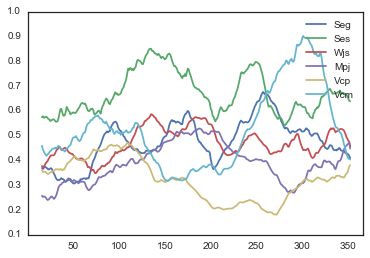

In [16]:
fc_clim, gpp_clim, re_clim, p_clim, vpd_clim = dict(), dict(), dict(), dict(), dict()

for site in sites:
    fc_clim[ site ] = get_climatology( d[ site ]['FC_F_g_int' ] )
    gpp_clim[ site ] = get_climatology( d[ site ][ 'GPP_g_int' ] )
    re_clim[ site ] = get_climatology( d[ site ][ 'RECO_g_int' ] )
    p_clim[ site ] = get_climatology( d[ site ][ 'P_F_sum' ] )
    vpd_clim[ site ] = get_climatology( d[ site ][ 'VPD_F_avg' ] )
    #gpp_clim[site].allyr_stderr.plot()
    re_clim[site].allyr_cv.rolling(window=30, center=True).mean().plot()
plt.legend(sites)